<a href="https://colab.research.google.com/github/royam0820/Notebooks/blob/master/amr_Tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Understanding the inner workings of Large Language Models (LLMs) requires a good look at the very first step in the generative process: **Tokenization**.<br>
The task seems simple enough: Find a way to most fittingly represent input text by some numeric token representation.

However, this translation often turns out to be the cause for many downstream issues if done incorrectly.

## Flashback: Character-Level Tokenization

In the last lesson, we actually (somewhat) implemented tokenization for our GPT model.<br>
Let's revisit this and go through what we did:

In [18]:
! pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.9 MB/s eta 0:00:00


In [19]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import regex as re
import tiktoken
import os
import json

First, we took a sample dataset from a text file and loaded it to memory:

In [20]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset - file input.txt
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-03-20 17:51:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-03-20 17:51:28 (19.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [21]:
# Read the txt file to inspect it
with open('input.txt', 'r') as f:
    text = f.read()

# Print a sample of the text (First 100 characters)
print("Length of Dataset:", len(text), "\n")
print(text[:100])

Length of Dataset: 1115394 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


We determined the unique characters present in the dataset:

In [22]:
chars = sorted(list(set(text))) # Get all unique characters in the text
vocab_size = len(chars)         # Length of vocabulary (this includes the space character and newline)
print('Unique Characters:', ''.join(chars))
print(f'\nVocabulary size: {vocab_size}')

Unique Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Vocabulary size: 65


We then went on and mapped each unique character to a unique integer, allowing for a fully numeric representation of the dataset:

In [23]:
stoi = { ch:i for i,ch in enumerate(chars) }     # Character to index mapping
itos = { i:ch for i,ch in enumerate(chars) }     # Index to character mapping

# This is the encoder; Encode a string to a list of integers
encode = lambda s: [stoi[c] for c in s]
# This is the decoder; Decode a list of integers to a string
decode = lambda l: ''.join([itos[i] for i in l])

msg = "hii there"
token_list = encode(msg)
print(token_list)
print(decode(token_list))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


> The above implemented approach is called *character-level tokenization*.

Encoding the sum of characters in the input text file would now result in an equal sum of tokens for the GPT to process.<br>
But, we didn't stop there just yet.<br>
<br>
We went on to built a Look-Up-Table (LUT) to map each numeric token to a vector representation.<br>
<br>
**Why did we take this extra step?**<br>
The vocabulary representation by $65$ vectors (one per token) á $65$ dimensions (one per token, again) enabled a fixed-resolution representation for each token.<br>
We then left it up to `BigramLM` to optimize some representation per token inside this token's vector representation.<br>
<br>
All in all, a uniformly sized representation through vectors allowed us to better capture compositional relationships between characters.<br>
Think of it like so: Characters that are semantically or functionally similar can now have similar vector representations. Therefore, vowels or consonants may cluster together in the vector space, making it easier for GPT to capture similarities in associations. This really makes vectors a lot more expressive than discrete, integer-based representations.

The Embedding Layer `BigramLM` that achieved all of this looked like so:

In [24]:
torch.manual_seed(1337) # for reproducibility

# Not really an LM at this stage, but we will get there...
class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # Embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors

    def forward(self, idx, targets):
        # idx is of shape (batch_size, block_size)
        # targets is of shape (batch_size, block_size)
        logits = self.embed(idx)
        return logits # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)

Even with the above described $65 \times 65$ embedding matrix, it turns out that we only implemented a relatively inefficient tokenization.<br>
In reality, token vocabularies are much differently constructed, above and beyond the character-level.

> Text is actually not tokenized on character-level, but on chunk-level.

Our goal is to find and explore a way to tokenize text on a chunk-level, instead of a character-level.<br>
Let's go!

Designed as a walkthrough with this [YouTube video](https://colab.research.google.com/drive/1y0KnCFZvGVf_odSfcNAws6kcDD7HsI0L?usp=sharing)

# Tokenization :(

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

- Why can't LLM spell words? **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- Why is LLM worse at non-English languages (e.g. Japanese)? **Tokenization**.
- Why is LLM bad at simple arithmetic? **Tokenization**.
- Why did GPT-2 have more than necessary trouble coding in Python? **Tokenization**.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.
- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.
- Why the LLM break if I ask it about "SolidGoldMagikarp"? **Tokenization**.
- Why should I prefer to use YAML over JSON with LLMs? **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

---

Good tokenization web app: [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app)

Example string:

```
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
```

---

Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.


```
<br>

![](https://github.com/MK2112/nn-zero-to-hero-notes/blob/main/images/Tiktoken_Vercel_1.png?raw=1)

With each color representing a different token, it becomes evident that GPT-2's tokenizer is not caracter-level.<br>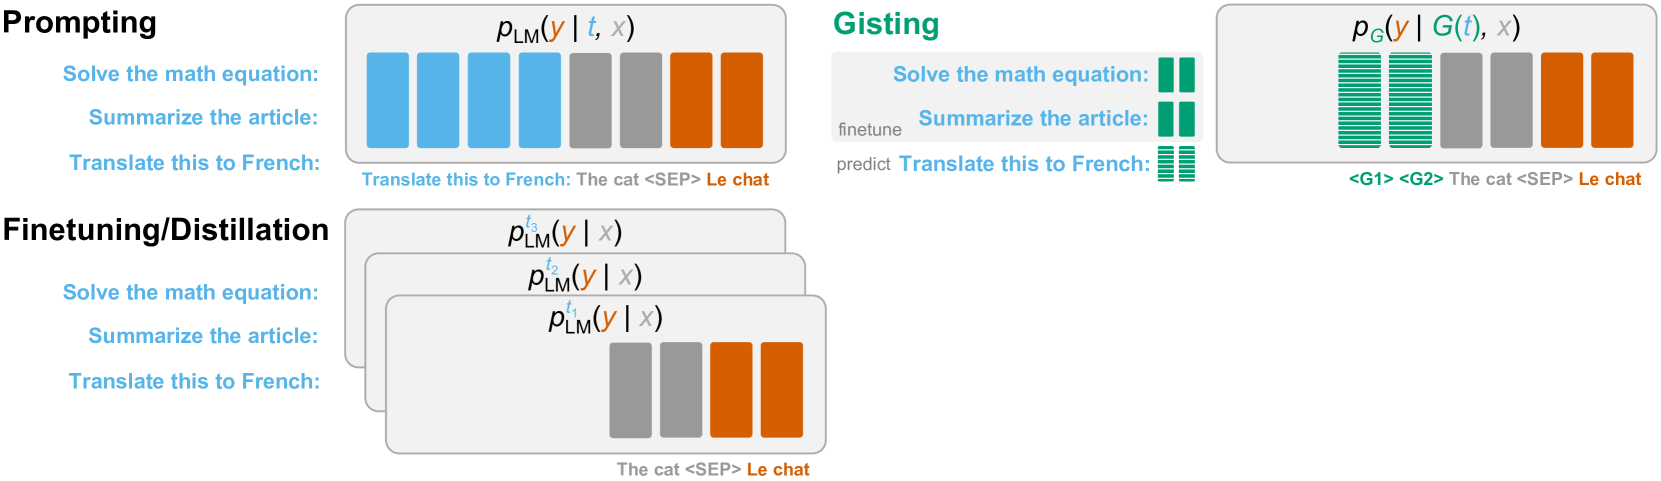
<br>
This might not have too much of an impact on plain text, but take a look at the tokenization of the arithmetic operations.<br>
- Every numeric value except $127$ is sliced into multiple tokens.<br>
- Logical mis-slicing can be problematic here, as it may lead to challenges in preserving the semantic meaning of any numerical or arithmetic expression.<br>

Curiously, the word "Egg" is tokenized in four different ways, depending on the degree of capitalization and leading space. So, depending on the location of the word in the sectence, upper case, lowercase, the tokenization can be arbitraly different. The language model has now to learn from the raw data, from all the internet text that it is going to be training on that these are actually all the exact same concept and it has to group them in the parameters of the NN and understand, based on the data patterns, that they are all very similar

The tokenization of Korean text is more granular compared to that of English text. This can to a great extent be attributed to representational imbalance in the training data.
- A Korean-speaking end-user might have to pay a higher price to an LLM provider than an English-speaking end-user, just because of poorer/more granular tokenization.<br>

Additionally, having more tokens ultimately representing the same amount of data results in a more rapidly filled attention buffer downstream. This inevitably leads to an overall decrease in the performance of the LLM.

With the Python code example, each whitespace is tokenized individually. This reduces the interpretability of the code for the LLM, as the context window is rapidly spammed with whitespace tokens.<br>
Just like with the Korean text, this will negatively impact network performance.

When providing the same input to the GPT-4 tokenizer, `cl100k_base`, we pretty much half the token count.
This implies the tokenizer has approximately a twice as large vocabulary as the GPT-2 tokenizer:

![](https://github.com/MK2112/nn-zero-to-hero-notes/blob/main/images/cl100k_base_1.png?raw=1)

> The increase in vocabulary size *alone* enables GPT-4 to pretty much double the context window size, compared to GPT-2.

# Unicode

In [25]:
some_text = "안녕하세요 👋 (hello in Korean!)"
type(some_text)

str

NB: the string above shows that we want to support not only English but also another foreign language, i.e. Korean, and also emoji. The data type `str` shows in the Python's documentation that is a sequence of Unicode code points.

The [documentation](https://docs.python.org/3/library/stdtypes.html#text-sequence-type-str) states that Python's `str` type is a **sequence of [Unicode](https://en.wikipedia.org/wiki/Unicode) codepoints**.<br>
Unicode is a character encoding standard, mapping each character to a unique integer value.<br>
We can read this value by using the `ord()` function:

In [26]:
# using Python ord function to return the Unicode code point for a single character
print(ord("👋"))
print([ord(x) for x in some_text])

128075
[50504, 45397, 54616, 49464, 50836, 32, 128075, 32, 40, 104, 101, 108, 108, 111, 32, 105, 110, 32, 75, 111, 114, 101, 97, 110, 33, 41]


NB: with the `ord("h") function, you cannot plug-in strings only a single caracter, since unicode will display only one single code point.

So that's it, we solved our encoding problem, ... right?<br>
Well, no.<br>
<br>
While Unicode is comprehensive, it is changing, evolving, and already pretty vast. It is not stable.<br>
But, Unicode has defined three encoding forms which are stable and can be used to represent<br>a subset of Unicode characters: [UTF-8](https://en.wikipedia.org/wiki/UTF-8), [UTF-16](https://en.wikipedia.org/wiki/UTF-16), and [UTF-32](https://en.wikipedia.org/wiki/UTF-32).<br>
Representation through the encodings is achieved by a sequence of bytes, with each byte representing a codepoint.<br>

> **Why can Unicode represent characters by integer, but UTF-8, UTF-16, and UTF-32 use bytes?**<br>
> UTF-8, UTF-16, and UTF-32 are encoding schemes, defining how Unicode is represented in binary form (sequences of bytes) for storage and transmission.<br>
> For example, UTF-8 is specifically designed to handle the evolving nature of the Unicode standard while remaining stable itself.

With UTF-8, you predictably can represent Unicode characters by a sequence of $1$ to $4$ bytes. This is fixed.<br>
You may refer to [Nathan Reed's Blogpost on Unicode](https://www.reedbeta.com/blog/programmers-intro-to-unicode/) for further details, especially for the [UTF-8 Everywhere Manifesto](https://utf8everywhere.org/).

The following is the set of raw bytes representing our string according to UTF-8:

In [27]:
# raw bites of the utf-8 encoding
list(some_text.encode('utf-8'))

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

Using directly the raw UTF-8 bytes would be very inefficient for language models. It would lead to extremely long sequences with a small vocabulary size of only 256 possible byte values. This prevents attending to sufficiently long contexts.

The solution is to use a byte pair encoding (BPE) algorithm to compress these byte sequences to a variable amount. This allows efficiently representing the text with a larger but tunable vocabulary size.

# Daydreaming: Deleting Tokenization in Language Models

In this article [\[Yu et al. 2023\]](https://arxiv.org/abs/2305.07185), we explore the idea of removing tokenization from language models, as proposed in a paper from the summer of last year. While this would be an amazing achievement, allowing us to feed byte streams directly into our models, it comes with some challenges.


## The Problem with Long Sequence

One of the main issues with removing tokenization is that attention becomes extremely expensive for very long sequences. To address this, the paper proposes a hierarchical structuring of the Transformer architecture that could allow feeding in raw bytes.

> MEGABYTE is a new technology designed to help computers understand and generate very long texts, images, or sounds by breaking them down into smaller parts, similar to how you might tackle a large puzzle by doing small sections at a time. It uses two main parts:  one that focuses on the details within each small section, and another that looks at how all these sections fit together. This way, it can handle much larger amounts of information than before, making it better at tasks like creating high-quality images, understanding complex documents, or producing realistic sounds.

## The Current State of Affairs
For now, we still need to compress text using the Byte Pair Encoding (BPE) algorithm before feeding it into language models. The BPE algorithm is not overly complicated, and its Wikipedia page provides a good walkthrough.

Tokenization-free modeling would be a significant breakthrough, and hopefully, future research will make it a reality. Until then, we must rely on established methods like BPE to preprocess our input data.

# Byte Pair Encoding (BPE) Algorithm Walkthrough

The [Wikipedia article on Byte Pair Encoding (BPE)](https://en.wikipedia.org/wiki/Byte_pair_encoding) is quite hands-on and definitely recommended.<br>

> Iteratively, for a given text, BPE merges the most frequent pair of consecutive tokens into a single new token, which we then add to our vocabulary.<br> We repeat this until we reach a predefined vocabulary size.<br>

You can see how this can build up token hierarchies, as the most frequent pairs are merged first, and then the next most frequent pairs, and so on.<br>
<br>
Let's see how this works in practice:

In [28]:
# Text is the first paragraph from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience
print('---')
print(text)
print("length:", len(text))
print('---')
print(tokens)
print("length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

NB: the paragraph stored in the `text` variable has a total length of 533 code points. Below are the bytes encoded into UTF-8 with a length of 616 bytes (616 tokens). The total length is longer because a lot of these simple ascii characters they just become a single byte, whereas other characters like `🅤🅝🅘🅒🅞🅓🅔‽` they become multiple bytes, up to 4, so we are expanding the total length's size.

Now, let's iterate other is text, and find the pair of bytes that occur most frequently to merge them after our findings.

In [29]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]): # Sliding Window of size 2 across tokens
        counts[pair] = counts.get(pair, 0) + 1
    return counts

stats = get_stats(tokens)
print(stats)

{(239, 188): 1, (188, 181): 1, (181, 239): 1, (239, 189): 6, (189, 142): 1, (142, 239): 1, (189, 137): 1, (137, 239): 1, (189, 131): 1, (131, 239): 1, (189, 143): 1, (143, 239): 1, (189, 132): 1, (132, 239): 1, (189, 133): 1, (133, 33): 1, (33, 32): 2, (32, 240): 3, (240, 159): 15, (159, 133): 7, (133, 164): 1, (164, 240): 1, (133, 157): 1, (157, 240): 1, (133, 152): 1, (152, 240): 1, (133, 146): 1, (146, 240): 1, (133, 158): 1, (158, 240): 1, (133, 147): 1, (147, 240): 1, (133, 148): 1, (148, 226): 1, (226, 128): 12, (128, 189): 1, (189, 32): 1, (159, 135): 7, (135, 186): 1, (186, 226): 1, (128, 140): 6, (140, 240): 6, (135, 179): 1, (179, 226): 1, (135, 174): 1, (174, 226): 1, (135, 168): 1, (168, 226): 1, (135, 180): 1, (180, 226): 1, (135, 169): 1, (169, 226): 1, (135, 170): 1, (170, 33): 1, (159, 152): 1, (152, 132): 1, (132, 32): 1, (32, 84): 1, (84, 104): 1, (104, 101): 6, (101, 32): 20, (32, 118): 1, (118, 101): 3, (101, 114): 6, (114, 121): 2, (121, 32): 2, (32, 110): 2, (110,

NB: This function `get_stats(ids)` uses `zip(ids, ids[1:])` to iterate over consecutive elements of the input list in a Pythonic way. It then builds a dictionary counts where the keys are tuples of consecutive elements and the values are the number of occurrences.

In [30]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]): # Sliding Window of size 2 across tokens
        counts[pair] = counts.get(pair, 0) + 1
    return counts

stats = get_stats(tokens)
print("invert key-value pair sorted by key (count): ")
print(sorted(((v,k) for k,v in stats.items()), reverse=True)) # Invert key-value relationship and sort by key (count)
print("5 most common bigrams written out: ")
print(sorted(((v,(chr(k[0]), chr(k[1]))) for k,v in stats.items()), reverse=True)[:5]) # Just for fun, 5 most common bigrams written out

top_pair = max(stats, key=stats.get) # Retrieve the most common bigram
print(f"top pair:", {top_pair})

invert key-value pair sorted by key (count): 
[(20, (101, 32)), (15, (240, 159)), (12, (226, 128)), (12, (105, 110)), (10, (115, 32)), (10, (97, 110)), (10, (32, 97)), (9, (32, 116)), (8, (116, 104)), (7, (159, 135)), (7, (159, 133)), (7, (97, 114)), (6, (239, 189)), (6, (140, 240)), (6, (128, 140)), (6, (116, 32)), (6, (114, 32)), (6, (111, 114)), (6, (110, 103)), (6, (110, 100)), (6, (109, 101)), (6, (104, 101)), (6, (101, 114)), (6, (32, 105)), (5, (117, 115)), (5, (115, 116)), (5, (110, 32)), (5, (100, 101)), (5, (44, 32)), (5, (32, 115)), (4, (116, 105)), (4, (116, 101)), (4, (115, 44)), (4, (114, 105)), (4, (111, 117)), (4, (111, 100)), (4, (110, 116)), (4, (110, 105)), (4, (105, 99)), (4, (104, 97)), (4, (103, 32)), (4, (101, 97)), (4, (100, 32)), (4, (99, 111)), (4, (97, 109)), (4, (85, 110)), (4, (32, 119)), (4, (32, 111)), (4, (32, 102)), (4, (32, 85)), (3, (118, 101)), (3, (116, 115)), (3, (116, 114)), (3, (116, 111)), (3, (114, 116)), (3, (114, 115)), (3, (114, 101)), (3, (

NB1: It prints the inverted key-value pairs sorted by count in descending order.
This is achieved by sorting a generator expression that swaps keys and values from the stats dictionary.

Then, it prints out the 5 most common bigrams along with their counts by sorting them by frequency and converting the integer keys back to character pairs.

Finally, it  prints the most common bigram along with its count.


NB2: the result indicates that the pair `(101,32)` occurs 20 times, the next pair `(240,159)` occurs 15 times and so on.

In [31]:
# printing the character value for the top pair (101, 32)
chr(101), chr(32)

('e', ' ')

NB: So the most common consecutive pair is `"e"` followed by ` ` a space, which makes sense as many English words end with "e" (i.e.: software ).

The token vocabulary at this point spans $0$ to $255$ because we are working with $8$-bit-representations/bytes.<br>
We can now create a new, $256^{th}$ token representing the most common pair, `('e', ' ')`:

In [32]:
def merge(ids, pair, idx):
    # Iterating through ids, if we find (pair) occuring, replace it by value idx
    newids = []
    i = 0
    while i < len(ids):
        # If we are not at the very last position AND the pair matches, replace it
        if i < len(ids)-1 and (ids[i], ids[i+1]) == pair:
            newids.append(idx)
            i += 2 # We skip over the now replaced pair
        else:
            newids.append(ids[i])
            i += 1
    return newids

# Sanity-Check, testing the merge function by replacing the pair (6, 7) by 99
print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

[5, 6, 99, 9, 1]


NB: The merge function takes a list of IDs, the pair to be replaced, and the new index (idx) as arguments. It iterates through the list, checking for consecutive occurrences of the pair and replacing them with the new token ID. If a match is found, the new ID is appended to the newids list, and the position is incremented by two to skip over the entire pair. If no match is found, the element at the current position is copied over, and the position is incremented by one.

In [33]:
# from our list of tokens, we replaced the top pair (101, 32) occuring 20 times by the value 256
tokens2 = merge(tokens, top_pair, 256)

print(tokens2, "\n")
print("Length of Token List:", len(tokens2))
print("All Occurrences Removed" if (True if top_pair not in zip(tokens2, tokens2[1:]) else False) else "Still Some Occurrences Left")

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 32, 226, 128, 156

NB: the length of the token list has decreased by 20, since we have replaced the top pair (101,32) by 256.

We effectively mapped our text to UTF-8, identified the most common pair of consecutive byte values (ranging from $0$ to $255$ in $8$-bit values), and replaced its occurences with a new token ($256$) representing the corresponding pair.<br>
That's all we did. We didn't keep track of this action through a vocabulary or anything, we just did it.

Now that we made sure our basic implementation works, we can loop over the tokens as many times as we want to actually build up a vocabulary.<br>
You can think of this vocabulary enrichment as iteratively building a binary tree from the leaves down to the root.<br>
<br>
We'll use the entire blog post for training:

In [34]:
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""

tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience

We can now add the vocabulary as a simple dictionary called `merges` that uses the pair as key and the representing token as value:

In [35]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]): # Sliding Window of size 2 across tokens
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
  # Iterating through ids, if we find (pair), replace it by value idx
  newids = []
  i = 0
  while i < len(ids):
    # If we are not at the very last position AND the pair matches, replace it
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2      # We skip over the now replaced pair
    else:
      newids.append(ids[i])
      i += 1
  return newids

# ---
vocab_size = 276 # # Our (Arbitrary) Target Vocabulary Size
num_merges = vocab_size - 256 # 20 merges will be done
ids = list(tokens) # copy so we don't destroy the original list

merges = {} # (int, int) -> int - Merge dictionary; Think of this as key: (child1, child2), value: parent/new token
for i in range(num_merges):
  stats = get_stats(ids)
  pair = max(stats, key=stats.get)    # Retrieve the most common bigram
  idx = 256 + i
  print(f"merging {pair} into a new token {idx}")
  ids = merge(ids, pair, idx)
  merges[pair] = idx

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (101, 114) into a new token 260
merging (99, 111) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (111, 114) into a new token 266
merging (100, 32) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (261, 100) into a new token 271
merging (121, 32) into a new token 272
merging (46, 32) into a new token 273
merging (97, 108) into a new token 274
merging (259, 256) into a new token 275


NB1: Note the merging of `(101, 32)` into `256` will be applied only if they appear together. If not, tokens `101` and `32` will remain in the tokens list. Also, the new token `256` is also eligible for merging as seen on the last line of the output result.

NB2: the vocabulary size is a balancing act that requires consideration of your specific task, dataset, model architecture, computational resources, and empirical testing. There is no one-size-fits-all answer, but following these guidelines can help you approach the problem methodically.

Comparing the enriched vocabulary to the original one, we can see that we now need fewer tokens to represent the same amount of data because we are able to represent more complex chunks of text with a single respective token:

In [37]:
print("tokens length in bytes:", len(tokens))
print("ids length after merging 20 times:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length in bytes: 24597
ids length after merging 20 times: 19438
compression ratio: 1.27X


Note, the **Tokenizer** is a completely separate, independent module from the LLM. **It has its own training dataset of text** (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

**The Tokenizer can be seen as a translation layer** between raw text as we saw in the sequence of Unicode code points. You can take raw text and encode it into a token sequence and vice-versa, taking a token sequence and translate it (decode it) back into raw text.

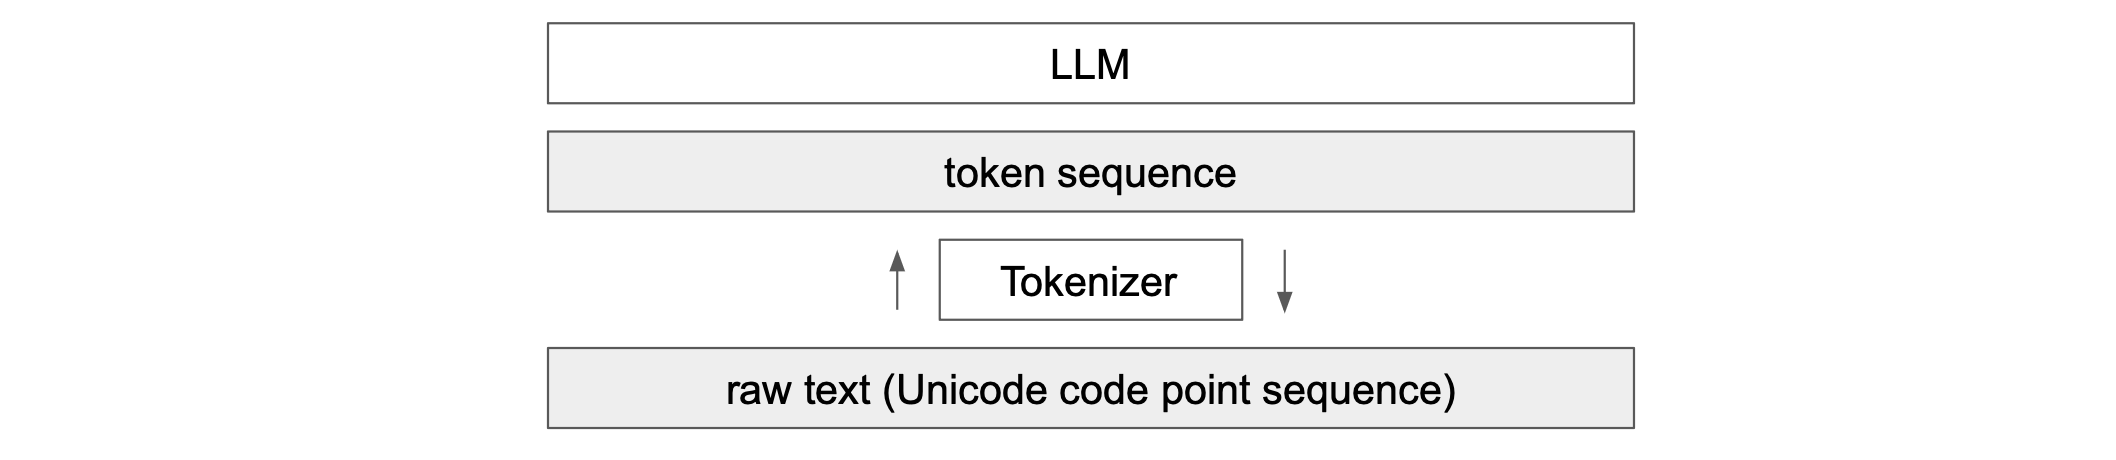

We now want to create a Tokenizer that goes beyond character-level tokenization and represents some chunks by some identifying value.
From there, we can go on and build a Look-Up-Table to map each chunk-token to a vector representation. This step remains as before.

Oh, and before we forget, this time the tokenizer should be able to handle different scriptural systems, too. And Emojis, we need Emoji support!



### Decoding Tokens to Strings

With encoding done, given a sequence of integer tokens within range  [0; 𝑣𝑜𝑐𝑎𝑏_𝑠𝑖𝑧𝑒] , what is the text string?

In [38]:
# Decoder Preprocessing: Mapping from token-id to bytes-object for that token
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():    # This needs to run in the order in which we inserted items into merges (use Python >= 3.7)
    vocab[idx] = vocab[p0] + vocab[p1]  # Populate at idx (parent integer) with concatenated bytes-object of children p0 and p1, format is {idx: b'p0p1'}

def decode(ids):
  # Given ids (list of integers), return the Python string
  tokens = b"".join(vocab[idx] for idx in ids)      # Concatenate all the bytes-objects for each new token-id
  text = tokens.decode("utf-8")   # Decode the bytes into a Python string
  return text


NB: We create a preprocessing variable called `vocab`, which is a dictionary mapping from token ID to the bytes object for that token. We begin with the raw bytes for tokens 0 to 255. Then we iterate over the `merges` in the order they were inserted, populating the vocab dictionary by concatenating the bytes of the children tokens. It's important to iterate over the dictionary items in the same order they were inserted, which is guaranteed in Python 3.7+.

CODE EXPLAINATION - Preprocessing and `decode(ids`) function

**Vocabulary Initialization**
The `vocab` dictionary is initialized, **mapping integer indices to bytes objects**. Each index from 0 to 255 is mapped to a bytes object containing that index as a single byte.

**Merging Tokens**:
- The code iterates over items in the merges dictionary, which likely contains pairs of tokens to be merged.
- **For each pair (p0, p1) and its corresponding index idx, the vocab dictionary is updated**. The entry at index idx is set to the concatenation of the bytes objects at indices p0 and p1.

**Decoding Function**
The decode function takes a list of integers (`ids`) as input.
It retrieves the corresponding bytes objects from the vocab dictionary for each integer in ids and concatenates them using `b"".join().`
The concatenated bytes are then decoded into a Python string using UTF-8 encoding.

**Ok, what did we just do?**<br>
<br>
The dictionary `vocab` in a first step is made to hold byte-objects as values to the respective integer keys $0$ to $255$ as keys.<br>
In addition to this 'base-mapping' of `int -> byte(int)`, we now want to store the `new_token` as the key and `(token1, token2)` as the value.<br>
You can think of it as reversing the key-value relationship from `(token1, token2) -> new_token` in `merges` to now be `new_token -> (token1, token2)` in `vocab`.<br>
However, `vocab` will not store `(token1, token2)` as a tuple. Instead, it will store the concatenation of the two bytes-objects, hence `vocab[p0] + vocab[p1]` or `byte(token1) + byte(token2)`.

> `vocab` now holds the mapping for every `token` (not only `new_token`, but all tokens) integer to either a single byte, or the concatenation of the two bytes-objects that were merged to create `new_token`.

The `decode` function then goes to receive a list of token integers and iteratively indexes into `vocab` at the respective token integer to step-by-step join together the byte-objects to form a string.<br>
Finally, UTF-8 decoding is used to convert the byte-objects to something more readable, ideally closely resembling the original text.<br>
<br>
You might have noticed that this still has an implementation issue left, though:

In [46]:
# amr
vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [47]:
print(decode([97]))  # Works out to be "a"
print(decode([128])) # Works out to be ... flawed?!

a


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

#### Handling Invalid UTF-8 Sequences

One issue with this implementation is that it can throw an error if the token sequence is not a valid UTF-8 encoding. For example, trying to decode the single token 128 results in an error:

`UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte`  
  
This is because the binary representation of 128 is 10000000, which is not a valid UTF-8 sequence according to the encoding rules. To handle this, we can pass `errors="replace"` to the decode function, which replaces invalid bytes with the Unicode replacement character (�).

The standard practice is to use `errors="replace"` when decoding. If you see the replacement character in your output, it means something went wrong and the language model output an invalid sequence of tokens.

In summary, decoding is the process of converting a sequence of token IDs back into a human-readable string. It involves looking up the bytes for each token, concatenating them, and decoding the result from UTF-8. Handling invalid UTF-8 sequences is important to avoid errors and indicate when the model produces an invalid output.

Mapping $128_{10}$ to binary, we get $1000\ 0000_{2}$, which is not a valid UTF-8 start byte as per [Wikipedia](https://en.wikipedia.org/wiki/UTF-8#Encoding).<br>
We provide $1000\ 0000_{2}$, but only either $0xxx\ xxxx_{2}$ or $110x\ xxxx_{2}$ start a valid UTF-8 byte representation.<br>
<br>
Luckily, we can fix this pretty easily:

In [48]:
# Decoder Preprocessing: Mapping from token-id to bytes-object for that token
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():   # This needs to run in the order in which we inserted items into merges (use Python >= 3.7)
    vocab[idx] = vocab[p0] + vocab[p1] # Populate at idx (parent integer) with concatenated bytes-object of children p0 and p1

def decode(ids):
    # Given ids (list of integers), return the Python string
    tokens = b"".join(vocab[idx] for idx in ids)     # Concatenate all the bytes-objects for each new token-id
    text = tokens.decode("utf-8", errors="replace")  # Decode the bytes into a Python string
    return text

In [40]:
print(decode([97]))  # Works still
print(decode([128])) # Works now

a
�


**Why is `errors=replace` effective?**<br>
<br>
See the [Python Documentation](https://docs.python.org/3/library/codecs.html#error-handlers): If the decoder encounters some byte sequence that can't be decoded into valid Unicode, the sequence will be replaced with a special Unicode replacement character (U+FFFD). We basically take a graceful step over the invalid byte sequence, exclaim "I don't know what this is", and move on.<br>
<br>
**If we just take a step over this issue now, how can this be a problem at all in the first place? Didn't we only input UTF-8 into the encoder? How could something else then return?**<br>
<br>
Well yes, we input UTF-8 into the encoder. But, in reality, we don't decode what we just tokenized. Decoding is done to the LLM output.<br>
And there, if you encounter an LLM output symbol of $128$, something went wrong on the LLM-side that is worth investing further training to avoid.<br>
<br>
**It feels like this implementation of `decode` is too shallow. How come this setup can consider that some tuples inside `merges` are themselves made up of `new_token`s? Wouldn't that give an error?**<br>
<br>
This implementation seems shallow only at first. It really isn't. We progressively build up `vocab` in the exact order that `new_token`s were added to `merges`. This way, the tuples represented by the `new_token` are guaranteed to already be in `vocab`, ready to be referenced. And if you reference a `new_token` already in `vocab`, you will get the concatenation of the bytes-objects that were merged to create `new_token`. The bytes-objects are recursively built up in `vocab`. So, if a `new_token` is found to represent a tuple of `new_token`s, the very underlying bytes-objects are found through recursive indexing into `vocab`, automatically. This makes the loop around `vocab[idx] = vocab[p0] + vocab[p1]` a very elegant solution to finding the actual byte-objects that represent each `new_token`.

In [ ]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}

### Encoding Strings to Tokens

The goal is to create a function that takes a string as input and returns a list of integers representing the tokens. This is the opposite direction of the decoding process covered in the previous section.

The implementation will involve several steps, including:

- Encoding the text into UTF-8 bytes
- Converting the bytes into a list of integers
- Iteratively merging pairs of tokens based on the merges dictionary

In [65]:
def encode(text):
  # given a string, return list of integers (the tokens) - the raw bytes
  tokens = list(text.encode("utf-8"))
  while len(tokens) >= 2:     # len(tokens) needs to be at least 2 for the merge to take place
    stats = get_stats(tokens)
    # If a pair isn't found in merges, it assigns an "infinity" value, effectively pushing such pairs to the end of the priority list.
    pair = min(stats, key=lambda p: merges.get(p, float("inf")))
    if pair not in merges:
      break # nothing else can be merged
    # If a mergeable pair is found, retrieve the index
    idx = merges[pair]
    # and take the current list of tokens, the pair to merge, and the index or new token identifier
    tokens = merge(tokens, pair, idx)
  # return the new token identifier
  return tokens

print(encode("Hello World!"))

[72, 101, 108, 108, 111, 32, 87, 266, 108, 100, 33]


NB: `32` is  a space in ascii.

Let's break down the key steps from the `encode(text)` function:

- The input text is encoded into UTF-8 bytes using text.encode("utf-8").
- The bytes are converted into a list of integers using list(...).
- A while loop is used to iteratively merge pairs of tokens based on the merges dictionary. This continues until no more merges can be performed.
- Inside the loop, the get_stats function is used to count the occurrences of each pair in the current token sequence.
- The pair with the lowest index in the merges dictionary is selected for merging using min(...) and a custom key function.
- If the selected pair is not found in the merges dictionary, the loop breaks since no more merges can be performed.
- Otherwise, the selected pair is merged into a single token using the merge function and the corresponding index from the merges dictionary.
- The loop continues until no more merges can be performed, and the final list of tokens is returned.

In [64]:
print(encode("H"))

[72]


In [61]:
print(encode(""))

[]


NB: For an empty string as input `("")`, no tokens are generated since there are no characters to encode. Therefore, the output would be an empty list [].

CODE EXPLAINATION: `def encode(text)`

**Tokenization**
The input string is first encoded into UTF-8 bytes using text.encode("utf-8"), and then converted into a list of integers tokens.

**Merging Tokens**
The code enters a loop that continues as long as there are at least two tokens in the list.
- It calculates statistics using a function get_stats(tokens) to determine potential pairs for merging.
- It identifies the pair with the **lowest merge cost** based on the merges dictionary, which likely contains merge information.
- If the identified pair is not in the merges dictionary, indicating it cannot be merged further, the loop breaks.
- Otherwise, it retrieves the index idx associated with the pair from the merges dictionary and merges the tokens using the merge(tokens, pair, idx) function.

**Return Tokens**:
- Once no more merges can be performed, the function returns the final list of tokens.


In [ ]:
# amr
stats = get_stats(tokens)
stats

In [ ]:
# amr
merges

NB: the lowest merge is at the bottom, that is `(259, 256)` with new token `275`. The new token `256` computed from the merge `(101, 32)` can be used again for another merge, as shown in our lowest merge.

In [59]:
# amr
pair = min(stats, key=lambda p: merges.get(p, float("inf")))
pair

(101, 32)

In [66]:
print(decode(encode("hello world")))

hello world


#### Testing and Validation
To ensure the correctness of the implementation, it's crucial to test the encode function with various input strings and validate the results. Here are a few test cases:

Encoding and decoding a string should result in the same string.
Encoding and decoding the training text used to train the tokenizer should produce the same text.
Encoding and decoding validation data that the tokenizer hasn't seen before should also work correctly.

In [45]:
# Encoding and decoding a string should result in the same string
text2 = decode(encode(text))
print(text2 == text)

True


In [46]:
# Encoding and decoding the training text used to train the tokenizer should produce the same text
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = decode(encode(valtext))
print(valtext2 == valtext)

True


### Forced splits using regex patterns (GPT series)
In the GPT-2 series, the tokenizer uses the byte pair encoding (BPE) algorithm. The paper mentions that while the space of model-able strings is large, many common characters, including numerals, punctuation, and other symbols, are unified within the BPE's standard Unicode vocabulary. However, BPE implementations often operate on Unicode code points rather than byte sequences, which leads to suboptimal merges.

To avoid this, GPT-2 prevents BPE from merging across character boundaries by using a regex pattern. The relevant code is found in the `encoder.py` file:







#### Analysing the Regex Pattern
The regex pattern is composed of several parts, separated by the "or" operator (`|`). Let's break it down:

- `'\s+\S'`: Matches one or more whitespace characters followed by a non-whitespace character.
- `'\p{L}+'`: Matches one or more Unicode letters.
- `'\p{N}+'`: Matches one or more Unicode digits.
- `'[^\s\p{L}\p{N}]+'`: Matches one or more characters that are not whitespace, letters, or digits (e.g., punctuation).
- `'\s+(?!\S)`': Matches one or more whitespace characters that are not followed by a non-whitespace character (i.e., trailing whitespace).

By applying this regex pattern to the input text, GPT-2 ensures that the BPE algorithm only merges tokens within each chunk, preventing undesired merges across character types.

In [77]:
# Enforcing merging rules with regex so that some type of characters should never be merged together
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pat,"Hello World!"))
print(re.findall(gpt2pat,"Hello World! how are you?"))

['Hello', ' World', '!']
['Hello', ' World', '!', ' how', ' are', ' you', '?']


NB: we are splitting a text into a list of text and all elements of this list are processed independently by the tokenizer will result into a token for each item in the list and then you will consider merges from the item in the list to finally join all these tokens into a token sequence.

In [80]:
print(re.findall(gpt2pat, "Hello've world123 how's are       you!!!?"))

['Hello', "'ve", ' world', '123', ' how', "'s", ' are', '      ', ' you', '!!!?']


NB: **Finding All Matches**:

`re.findall(gpt2pat, "Hello've world123 how's are you!!!?")`: This line searches the input string "`Hello've world123 how's are you!!!?`" for all non-overlapping matches to the gpt2pat pattern and returns them as a list.
The input string contains various elements that the pattern is designed to match, including contractions, numbers, and punctuation.

In [81]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2pat, example))

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


In conclusion, GPT-2's tokenizer employs a regex pattern to force splits across character categories before applying the BPE algorithm. This approach helps maintain the integrity of the tokenization process and prevents suboptimal merges that could negatively impact the model's performance. While the exact training code for the GPT-2 tokenizer has not been released, understanding the regex pattern provides valuable insights into how the tokenizer handles input text.

# OpenAI TikToken Library

TikToken is the [official](https://github.com/openai/tiktoken) OpenAI tokenizer implementation.<br>
It delivers an interface to the tokenizers used in GPT-2, GPT-3, and GPT-4:

### Differences Between GPT-2 and GPT-4 Tokenizers
To understand the differences between the GPT-2 and GPT-4 tokenizers, we can look at the `tiktoken/openai_public.py` file on Github, in the Tiktoken library. This file contains the definitions of the different tokenizers maintained by OpenAI.

Some key changes in the GPT-4 tokenizer include:

- Case-insensitive matching for apostrophes (e.g., 's, 'd, 'm)
- Different handling of whitespaces
- Numbers are only merged up to three digits

Additionally, the vocabulary size increased from roughly 50k in GPT-2 to around 100k in GPT-4.

While the full details of the pattern changes are complex, these are some of the main differences between the GPT-2 and GPT-4 tokenizers. The next step is to briefly walk through the GPT-2 encoder.py released by OpenAI.

In [82]:
import tiktoken

# GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("    hello world!!!"))

# GPT-4 (merges spaces)
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("    hello world!!!"))

[220, 220, 220, 23748, 995, 10185]
[262, 24748, 1917, 12340]


NB: in GPT4, the white spaces are merged, making the token sequence shorter.

### GPT2 Encoder

The GPT-2 encoder has a vocabulary size of 50,257 tokens. This includes 256 raw byte tokens, 50,000 merged tokens from the byte pair encoding (BPE) process, and one special token called the `<|endoftext|>` token.

Reference the GPT-2 [encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)

Download the vocab.bpe and encoder.json files.

In [83]:
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

--2024-03-20 20:27:40--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.209.18.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.209.18.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [application/octet-stream]
Saving to: ‘vocab.bpe’

vocab.bpe           100%[===================>] 445.62K  2.84MB/s    in 0.2s    

2024-03-20 20:27:40 (2.84 MB/s) - ‘vocab.bpe’ saved [456318/456318]

--2024-03-20 20:27:40--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.209.18.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.209.18.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [application/json]
Saving to: 

In [84]:
import os, json

with open('encoder.json', 'r') as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab"

with open('vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
# ^---- ~equivalent to our "merges"


NB: the code above loads a BPE tokenizer's vocabulary and merge rules from files, preparing them for use in tokenizing text.
- The vocabulary (encoder) maps tokens to integer IDs, and
- the merge rules (bpe_merges) define how tokens are combined to form more complex tokens during the tokenization process.

### Special Tokens
Special tokens in the context of tokenization in NLP are tokens that are reserved for specific purposes and carry a particular meaning. These tokens do not represent the usual linguistic content of the text (like words or punctuation) but instead are used to provide additional information about the text or to adjust the model's behavior.

In [85]:
# gpt2 encoder vocab
len(encoder) # 256 raw byte tokens. 50,000 merges. +1 special token <|endoftext|>

50257

In [86]:
encoder

{'!': 0,
 '"': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '*': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 ':': 25,
 ';': 26,
 '<': 27,
 '=': 28,
 '>': 29,
 '?': 30,
 '@': 31,
 'A': 32,
 'B': 33,
 'C': 34,
 'D': 35,
 'E': 36,
 'F': 37,
 'G': 38,
 'H': 39,
 'I': 40,
 'J': 41,
 'K': 42,
 'L': 43,
 'M': 44,
 'N': 45,
 'O': 46,
 'P': 47,
 'Q': 48,
 'R': 49,
 'S': 50,
 'T': 51,
 'U': 52,
 'V': 53,
 'W': 54,
 'X': 55,
 'Y': 56,
 'Z': 57,
 '[': 58,
 '\\': 59,
 ']': 60,
 '^': 61,
 '_': 62,
 '`': 63,
 'a': 64,
 'b': 65,
 'c': 66,
 'd': 67,
 'e': 68,
 'f': 69,
 'g': 70,
 'h': 71,
 'i': 72,
 'j': 73,
 'k': 74,
 'l': 75,
 'm': 76,
 'n': 77,
 'o': 78,
 'p': 79,
 'q': 80,
 'r': 81,
 's': 82,
 't': 83,
 'u': 84,
 'v': 85,
 'w': 86,
 'x': 87,
 'y': 88,
 'z': 89,
 '{': 90,
 '|': 91,
 '}': 92,
 '~': 93,
 '¡': 94,
 '¢': 95,
 '£': 96,
 '¤': 97,
 '¥': 98,
 '¦': 99,
 '§': 100

In [54]:
encoder['<|endoftext|>'] # the only special token in use for the GPT-2 base model

50256

### Extenting the tokenizer
It is possible to extend the tokenizer by adding more special tokens. The tiktoken library allows you to create your own encoding object by specifying additional special tokens:
```
cl100k_base = tiktoken.get_encoding("cl100k_base")

special_tokens={
  "<|im_start|>": 100264,
  "<|im_end|>": 100265,
}
```

When adding special tokens, it is necessary to perform model surgery on the transformer and its parameters. This includes extending the embedding matrix for the vocabulary tokens and the final layer of the transformer to accommodate the new tokens.

## GPT4 Tokenizer
The GPT-4 tokenizer differs from the GPT-2 tokenizer in terms of the special tokens used. In addition to the "`end of text`" token, GPT-4 includes four additional tokens: "`fim_prefix`", "`fim_middle`", "`fim_suffix`", and an additional "`endofprompt`" token. These special tokens are commonly used in fine-tuning the model for specific tasks, such as converting a base model into a chat model like ChatGPT.

In conclusion, understanding the concept of special tokens is crucial when working with tokenizers in large language models like GPT-2 and GPT-4. By leveraging special tokens, you can delimit documents, introduce special structures, and fine-tune models for specific tasks. The flexibility to extend tokenizers with custom special tokens allows for greater control and customization in natural language processing applications.

### minbpe exercise
minbpe is Minimal, clean code for the (byte-level) Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization. The BPE algorithm is "byte-level" because it runs on UTF-8 encoded strings. It is currently being developed by Andrej Karpathy.

At this point you have everything you need to build your own GPT-4 tokenizer. This is the [exercise progression](https://github.com/karpathy/minbpe/blob/master/exercise.md) you may wish to follow. You'll note that it is part of the [minbpe](https://github.com/karpathy/minbpe) repo, which is the solution to that exercise, and is a cleaned up version of the code above.

In [55]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # GPT-4 tokenizer
print(enc.encode("안녕하세요 👋 (hello in Korean!)"))
print(enc.decode(enc.encode("안녕하세요 👋 (hello in Korean!)")) == "안녕하세요 👋 (hello in Korean!)")
# match the above for your own tokenizer, and also implement a train() function

[31495, 230, 75265, 243, 92245, 62904, 233, 320, 15339, 304, 16526, 16715]
True


# Sentencepiece Library

The open-sourced [Sentencepiece](https://github.com/google/sentencepiece) library can perform both training and inference for, amongst others, BPE tokenization.<br>

> Llama and Mistral models rely on Sentencepiece for tokenization.

With Tiktoken, we took our string data, decoded it to UTF-8, and then tokenized the Bytes from there.<br>
Sentencepiece runs BPE on the Unicode codepoints directly, not on the UTF-8 byte representations.<br>
It has an option `character_coverage` for what to do with codepoints that appear few times: It either maps them onto an UNK token, or, if `byte_fallback` is activated,
encodes them with UTF-8 and then tokenizes the raw bytes instead.<br>
<br>
Tiktoken is conceptually cleaner, Sentencepiece is more efficient.

In [87]:
import sentencepiece as spm

In [88]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

Docs for sentencepiece options:

- [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
- [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

In [89]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",

  # output spec
  model_prefix="tok400", # output filename prefix

  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,

  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,

  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=True,

  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,

  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1, # -1 we will not use pad_id

  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

# training sentencepiece
spm.SentencePieceTrainer.train(**options)


NB: When you train the tokenizer, the input file is the `toy.txt` file; the model will be called `tok400.model` as indicated in the options above: ` model_prefix="tok400"`




In [99]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')

# Inspect vocabulary off the model file
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]

print(f"vocab size:", {len(vocab)})
#print(f"vocabulary", vocab)
vocab

vocab size: {400}


[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

NB: the vocab contains at the beginning the special tokens:
```
['<unk>', 0],
['<s>', 1],
['</s>', 2],
```
Then the individual bytes tokens (256)


```
['<0x00>', 3],
['<0x01>', 4],
['<0x02>', 5],
['<0x03>', 6],
etc
```
After the bytes token comes the merges (parent nodes and their ids), and after the merges comes the individual code point tokens and their ids.

This is the vocab list of our training set file called `toy.txt`




Now that we have a vocabulary, we can encode into a list. See below.

In [91]:
ids = sp.encode("hello 안녕하세요")
print(ids)

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]


NB: the Korean characters were not part of our training set, so those code points are not in our vocabulary but since in our options we have `byte_fallback=True` so sentencepiece translates them into UTF-8 code points to represent them.

If we set the option `byte_fallback=False`, then in our vocab, we will not have the bytes token used in case of fall back, and the Korean sentence will be unknown with the token `0` for unknown.



In [92]:
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


NB: we can see the bytes token that have been used since `byte_fallback=True`

Here, Sentencepiece has encountered inputs that vocab does not account for. This would be problematic, if it weren't for `byte_fallback=True`.<br>
Sentencepiece then encodes the input as UTF-8 and tokenizes the raw bytes instead.

> If it weren't for `byte_fallback=True`, we'd get `['_', 'h', 'e', 'l', 'l', 'o', '_', '<unk>']` instead, because we never really saw the Korean characters in the training data, haven't mapped them to tokens, and so they are ruthlessly replaced with the UNK token.

While we're at it, why is there an extra `'_'` token in the front?<br>
It's caused by `add_dummy_prefix=True` in order to encode a mid-sentence `_hello` and a beginning-of-sentence `hello` equally.

The setup we justed walked-through is really close to how LLama was trained.<br>
Actually, refer to [this issue](https://github.com/google/sentencepiece/issues/121) below, if you want the exact setup for Llama.

**Llama 2 tokenizer proto**
If you'd like to export the raw protocol buffer for the `tokenizer.model` released by meta, this is a [helpful issue](https://github.com/google/sentencepiece/issues/121). And this is the result:

```
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}
```

# Looping Back: vocab_size

We already talked about this somewhat in the beginning of this lesson, but in the last lesson, we implemented `gpt.py` in PyTorch.<br>
Our vocab size was $65$. We represented each token by a vector of $65$ dimensions. Still, this was *character-level tokenization*.<br>
It becomes obvious that this approach scales poorly with a growing size of the vocabulary, because within each of the $65$ vector representations,<br>
we note the likelihood each of the $65$ tokens to follow the current token.

> The more this distribution grows, the less expressive each vector becomes on what token to output next.

In [63]:
torch.manual_seed(1337) # for reproducibility

# Not really an LM at this stage, but we will get there...
class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # Embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors

    def forward(self, idx, targets):
        # idx is of shape (batch_size, block_size)
        # targets is of shape (batch_size, block_size)
        logits = self.embed(idx)
        return logits # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)

Setting the vocabulary size is an important hyperparameter choice when working with transformer language models like GPT. It impacts model size, computational cost, and training efficiency. The optimal value depends on the specific application and is usually determined empirically. When necessary, an existing model's vocabulary can be extended through a straightforward resizing operation.

# Learning to Compress Prompts with Gist Tokens
Prompting is the primary way to utilize the multitask capabilities of language models (LMs), but prompts occupy valuable space in the input context window, and repeatedly encoding the same prompt is computationally inefficient. Finetuning and distillation methods allow for specialization of LMs without prompting, but require retraining the model for each task. To avoid this trade-off entirely, we present gisting, which trains an LM to compress prompts into smaller sets of "gist" tokens which can be cached and reused for computational efficiency.

[Learning to Compress Prompts with Gist Tokens](https://arxiv.org/html/2304.08467v3)

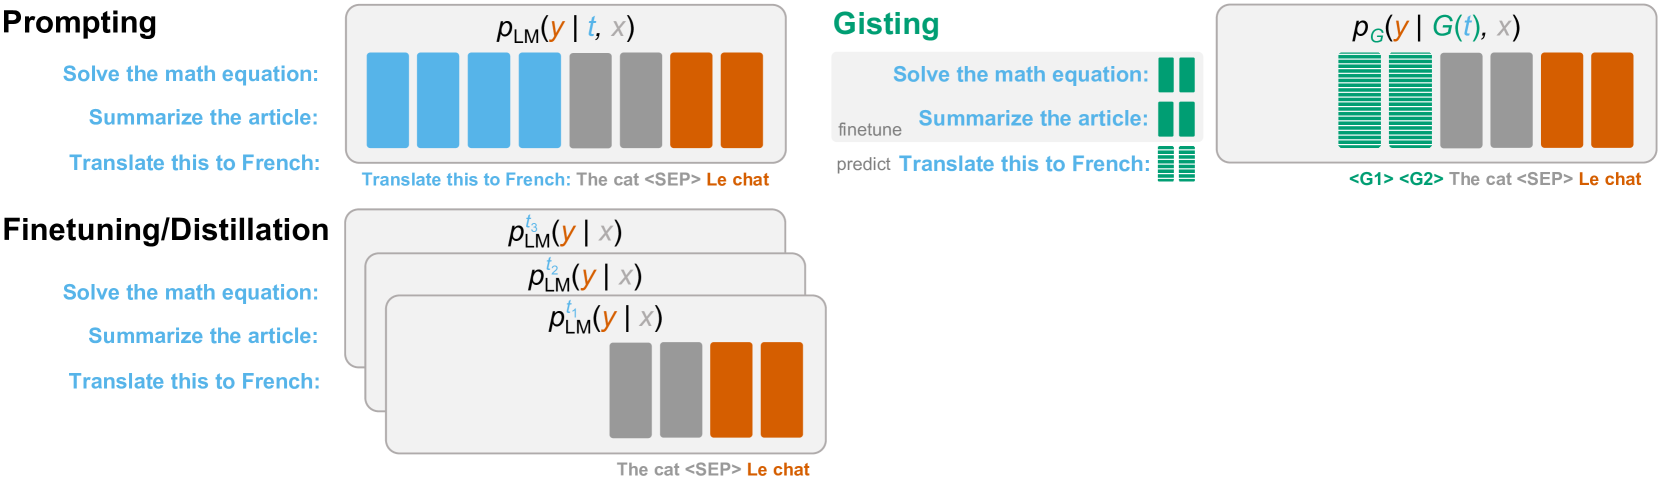

*Figure 1:Prompting retains the multitask capabilities of LMs, but is inefficient. Finetuning/distillation is more efficient, but requires training a model for each task. Gisting compresses prompts into activations on top of “gist tokens”, saving compute and generalizing to novel tasks at test time. Each vertical rectangle represents a stack of Transformer activations.*

In this paper, the authors propose a very simple way to learn a gist model: doing instruction tuning with gist tokens inserted after the prompt, and a modified attention mask preventing tokens after the gist tokens from attending to tokens before the gist tokens. This allows a model to learn prompt compression and instruction following at the same time, with no additional training cost.

On decoder-only (LLaMA-7B) and encoder-decoder (FLAN-T5-XXL) LMs, gisting achieves prompt compression rates of up to 26x, while maintaining output quality similar to the original models in human evaluations. This results in up to 40% FLOPs reduction and 4.2% latency speedups during inference, with greatly decreased storage costs compared to traditional prompt caching approaches.

## Gisting
Gisting is a technique for compressing long prompts into a few new "gist tokens". The model is trained by distillation, keeping the entire model frozen and only training the representations of the new tokens (their embeddings). The new tokens are optimized such that the behavior of the language model is identical to the model that has a very long prompt that works, effectively compressing that prompt into the gist tokens. At test time, the old prompt can be discarded and replaced with the gist tokens, which stand in for the long prompt with almost identical performance.

Gisting is an example of a parameter-efficient fine-tuning technique, where most of the model is fixed and the only trainable parameters are the token embeddings. This is just one example in a broader design space of applications in terms of introducing new tokens into a vocabulary that go beyond just adding special tokens and special new functionality.

# Multimodal Tokenization with Vector Quantization
Transformers have the capability to process not just text as the input modality, but also other modalities such as images, videos, audio, etc. To feed these modalities into a Transformer, you don't have to fundamentally change the architecture. You can tokenize your input domains and then treat them as if they were text tokens, keeping everything else identical.

For example, an early paper entitled [Taming Transformers for High-Resolution Image Synthesis](https://arxiv.org/abs/2012.09841) demonstrated how to chunk an image into integers, which essentially become the tokens of images:



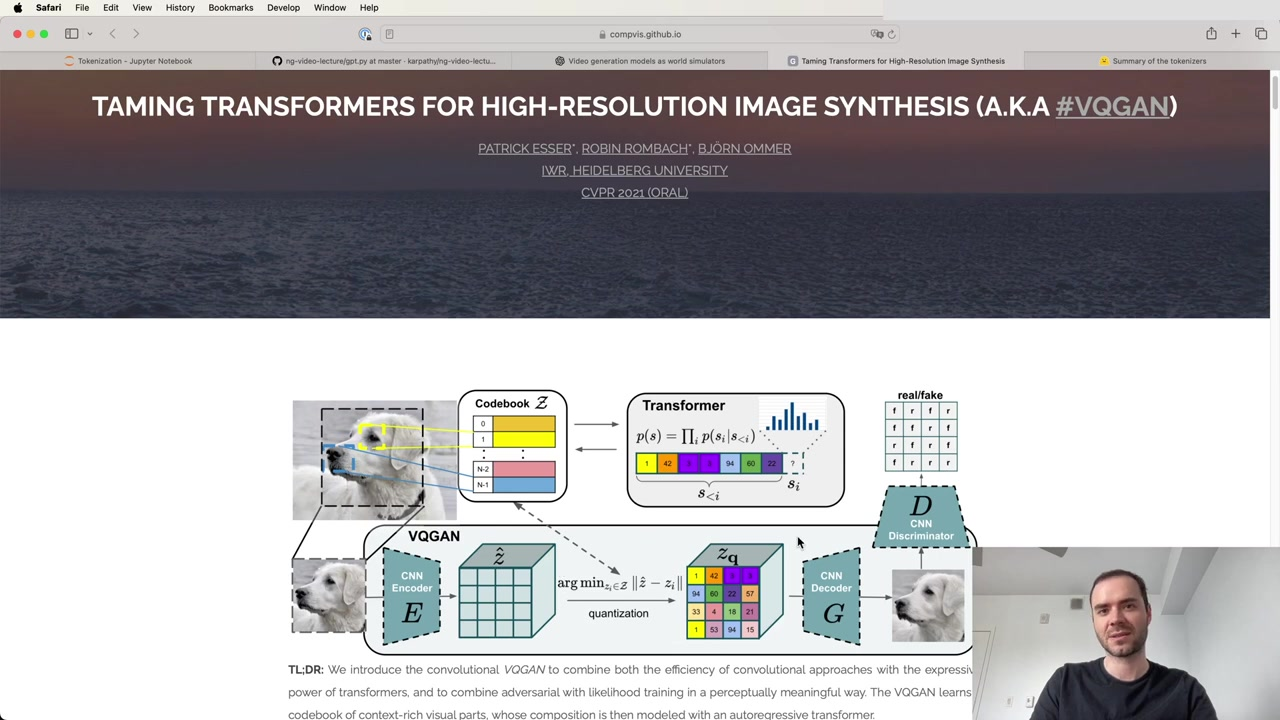

These tokens can be hard tokens (forced to be integers) or soft tokens (representations that go through bottlenecks like in autoencoders). OpenAI's SORA paper further showcases the potential of multimodal tokenization:

SORA has visual patches, which are essentially tokens with their own vocabulary. These discrete tokens can be processed with autoregressive models, while soft tokens can be processed with diffusion models. The exact design and processing of these tokens is an active area of research.

In summary, by tokenizing different modalities into a unified representation, Transformers can be applied to multimodal tasks without significant architectural changes. This approach opens up exciting possibilities for processing and generating images, videos, audio and more using the powerful capabilities of Transformers.

# Final recommendations

- Don't brush off tokenization. A lot of footguns and sharp edges here. Security issues. Safety issues.
- Eternal glory to anyone who can delete tokenization as a required step in LLMs.
- In your own application:
  - Maybe you can just re-use the GPT-4 tokens and tiktoken?
  - If you're training a vocab, ok to use BPE with sentencepiece. Careful with the million settings.
  - Switch to minbpe once it is as efficient as sentencepiece :)


# Conclusion

Honestly, modeling, reshaping and finetuning token vocabularies is a really interesting field of research, see [\[Mu et al. 2023\]](https://arxiv.org/abs/2304.08467).<br>
Beyond that, the question of vocabulary and tokenization increasingly drifts away from being exclusively a tool to model language.<br>
Papers like [\[Esser et al. 2020\]](https://arxiv.org/abs/2012.09841) for example investigate how to feed-in images as additional modalities to LLMs.<br>

> It seems that the field experiences a convergence in that the transformer is not to be touched, but the tokenization is to be extended. "Pretend this image is text, too." so to say.<br>
> This is what OpenAI SORA does, chunking image inputs efficiently into tokens and processing downstream with a transformer architecture.

Ok, to wrap things up, let's try to find answers to these earlier exclaimed issues:

- Why can't the LLM spell?
    - Characters are chunked up into differently sized tokens; The prompt `How many letters 'l' are in ".DefaultCellStyle"` gets various and false results. The model likely has difficulty answering questions about the number of specific letters in such a long token.
    [ChatGPT test](https://chat.openai.com/share/1d45d473-23e1-4baa-9f8f-fdc898952f9b).
- Why can't the LLM do simple text manipulations like reversing a string?
    - Again, characters are chunked up into differently sized tokens; This makes ChatGPT trip, but reversing `.D e f a u l t C e l l S t y l e` works for this reason.
- Why can an LLM turn out to be worse with non-English languages?
    - Lower representation in the training data leads to smaller (if any) tokenization of non-English characters. This bloats the Attention buffer. Bad.
- Why can't an LLM produce simple arithmetic operations correctly?
    - The tokenization of numbers in LLMs is arbitrary, with digits often split into multiple tokens. This makes it challenging for the model to perform character-level operations like addition, as it cannot easily refer to specific parts of a number. The inconsistent tokenization of numbers across different ranges further compounds this issue. Or, more fittingly, [Integer tokenization is insane](https://www.beren.io/2023-02-04-Integer-tokenization-is-insane/)
- Why could entering a special character like "<|endoftext|>" halt generation?
    - It's one of those special tokens. It is interpreted very specifically, therefore. Don't view it as a token, but as a command. [ChatGPT test](https://chat.openai.com/share/77981557-14da-4e00-9ac9-7cb0c2215738)
- Why can an LLM have hickups because of 'tailing whitespaces'?
    - Tokens, e.g. for GPT, often follow the pattern `(space)(something)`, so adding a space makes GPT try to come up with something fitting to this pre-existing space too, which is rare and therefore 'pollutes' the context. [OpenAI Playground test](https://platform.openai.com/playground/p/yCXYb4nebeGkVMKkWx59W7uw?model=gpt-3.5-turbo-instruct&mode=freeform)
- Why can an LLM break down when encountering capital letters within a word?
    - An LLM has never seen this before; It's confused and really quickly diverts to predicting end-of-word tokens. [OpenAI Playground test](https://platform.openai.com/playground/p/6kYXlUJubPpS7zht5sKcdh5b?mode=complete)
- Why may working with LLMs through YAML be better than through JSON?
    - YAML contains less special characters, so it's less likely to trip the tokenizer
- Why does LLM not actually mean end-to-end language modeling?
    - We need to Tokenize to form a uniform and scalable basis for text representation
- What on earth is going on with [`SolidGoldMagikarp`](https://www.lesswrong.com/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation)?
    - A peculiar cluster of tokens, including "SolidGoldMagikarp", was discovered in the GPT-2 token embeddings. When prompted with these tokens, the model exhibits bizarre behaviors, such as hallucinations, insults, and evasive responses. It is believed that the tokenization dataset included a significant amount of Reddit data mentioning the user "SolidGoldMagikarp". However, this data was likely not present in the language model's training set, resulting in these tokens remaining untrained and causing undefined behavior when encountered.

In conclusion, tokenization plays a crucial role in the performance and quirks of LLMs. Understanding these issues can help us better interpret model outputs and design more robust systems.
    - This absolutely broke LLMs like ChatGPT, essentially jailbreaking it. It seems `reddit.com/u/SolidGoldMagikarp` posted so often that the tokenizer knows it from its training, but the LLM doesn't. [OpenAI Playground test](https://platform.openai.com/playground/p/aANFFhvOrSNGrrjJvtAQbtfG?mode=complete)


> Eternal glory goes to those who can get rid of tokenization.


### Also worth looking at

- [Huggingface Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer). I didn't cover it in detail in the lecture because the algorithm (to my knowledge) is very similar to sentencepiece, but worth potentially evaluating for use in practice.

# References
References beyond Andrej Karpathy's lecture itself. Linked papers, blogposts, and other resources are listed here.

- [**Flashback: Character-Level Tokenization**](#flashback-character-level-tokenization)
- [**The Pitfalls of Tokenization**](#the-pitfalls-of-tokenization)
  - [Language Models are Unsupervised Multitask Learners \[Radford et al. 2019\]](https://insightcivic.s3.us-east-1.amazonaws.com/language-models.pdf)
  - [Tiktokenizer.vercel.app](https://tiktokenizer.vercel.app/)
- [**The Tokenizer Idea**](#the-tokenizer-idea)
  - [**Unicode**](#unicode)
    - [Nathan Reed - Programmer's Intro to Unicode](https://www.reedbeta.com/blog/programmers-intro-to-unicode/)
    - [UTF-8 Everywhere Manifesto](https://utf8everywhere.org/)
    - [MEGABYTE: Predicting Million-byte Sequences with Multiscale Transformers \[Yu et al. 2023\]](https://arxiv.org/abs/2305.07185)
- [**Byte-Pair Encoding**](#byte-pair-encoding)
  - [**Decoding**](#decoding)
  - [**Encoding**](#encoding)
- [**Going SOTA: Tokenizers in the Wild**](#going-sota-tokenizers-in-the-wild)
  - [**GPT Tokenizers**](#gpt-tokenizers)
    - [Language Models are Unsupervised Multitask Learners \[Radford et al. 2019\]](https://insightcivic.s3.us-east-1.amazonaws.com/language-models.pdf)
    - [Neural Machine Translation of Rare Words with Subword Units \[Sennrich et al. 2015\]](https://arxiv.org/abs/1508.07909)
    - [GitHub.com/openai/GPT-2](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
  - [**OpenAI TikToken**](#openai-tiktoken)
    - [GitHub.com/openai/tiktoken](https://github.com/openai/tiktoken)
  - [**Special Tokens**](#special-tokens)
    - [Efficient Training of Language Models to Fill in the Middle \[Bavarian et al. 2022\]](https://arxiv.org/abs/2207.14255)
  - [**Sentencepiece**](#sentencepiece)
    - [GitHub.com/google/sentencepiece](https://github.com/google/sentencepiece)
    - [GitHub.com/google/sentencepiece Issue #121](https://github.com/google/sentencepiece/issues/121)
- [**Exercise Time**](#exercise-time)
    - [GitHub.com/karpathy/minbpe](https://github.com/karpathy/minbpe)
- [**Looping Back: vocab_size**](#looping-back-vocab_size)
- [**Conclusion**](#conclusion)
    - [Learning to Compress Prompts with Gist Tokens \[Mu et al. 2023\]](https://arxiv.org/abs/2304.08467)
    - [Taming Transformers for High-Resolution Image Synthesis \[Esser et al. 2020\]](https://arxiv.org/abs/2012.09841)
    - [Beren Millidge: Integer tokenization is insane](https://www.beren.io/2023-02-04-Integer-tokenization-is-insane/)
    - [Jessica Rumbelow: SolidGoldMagikarp (plus, prompt generation)](https://www.lesswrong.com/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation)